In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from matplotlib.colors import LogNorm

import histlite as hl
import csky as cy

from glob import glob
%matplotlib inline
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

In [2]:
class GRECODataSpecs(object):
    class GRECODataSpec(cy.selections.CascadeSpec):
        _bins_sindec = np.linspace(-1., 1., 21)
        _bins_logenergy = np.linspace(0., 5., 31)
        def dataset_modifications(self, ds):
            max_sigma = np.radians(180)
            ds.data = ds.data[ds.data.sigma < max_sigma]
            ds.sig = ds.sig[ds.sig.sigma < max_sigma]
            #ds.data.sigma = np.minimum(ds.data.sigma, max_sigma)
            #ds.sig.sigma = np.minimum(ds.sig.sigma, max_sigma)
            
    class GRECO_IC86 (GRECODataSpec):
        _greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'
        _path_sig = _greco_base + 'IC86_2012.numu_with_angErr.npy'
        _path_data = sorted(glob(_greco_base + 'IC86_20*data_with_angErr.npy'))
        _path_grls = sorted(glob(_greco_base + 'GRL/IC86_20*data.npy'))
        #def __init__(self, years=list(map(str, 2010 + np.arange(1, 9)))):
        #    self.path_data = ['gfu/{{version}}/IC86_{}_data.npy'.format(y) for y in years]
        #    self.path_grls = ['gfu/{{version}}/GRL/IC86_{}_data.npy'.format(y) for y in years]
        #    self._key = 'GFU_for_' + '_'.join(years)
            
    greco = [GRECO_IC86]

In [3]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


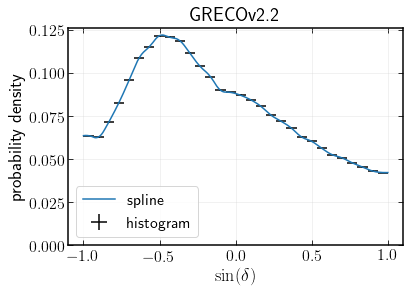

In [4]:
fig, ax = plt.subplots()
hl.plot1d (ax, greco_ana[0].bg_space_param.h, crosses=True, color='k', label='histogram')
sd = np.linspace (-1, 1, 300)
ax.plot (sd, greco_ana[0].bg_space_param(sindec=sd), label='spline')
ax.set_ylim(0)
ax.set_title(greco_ana[0].plot_key)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'probability density')
ax.legend(loc='lower left')
plt.show()

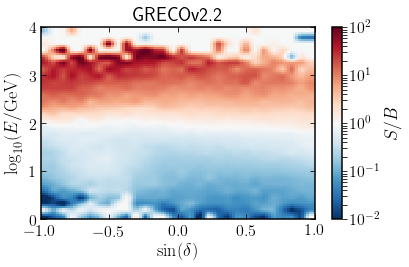

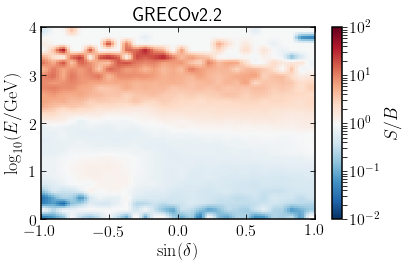

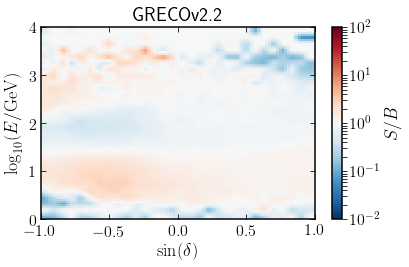

In [5]:
for gamma in [2.0, 2.5, 3.0]:
    fig, ax = plt.subplots()
    eprm = greco_ana[0].energy_pdf_ratio_model
    ss = dict(zip(eprm.gammas, eprm.ss_hl))
    things = hl.plot2d(ax, ss[gamma].eval(bins=100),
                       vmin=1e-2, vmax=1e2, log=True, cbar=True, cmap='RdBu_r')
    ax.set_title(greco_ana[0].plot_key)
    things['colorbar'].set_label(r'$S/B$')
    things['colorbar'].ax.tick_params(which='both', direction='out')
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_ylabel(r'$\log_{10}(E/\mathrm{GeV})$')
    plt.tight_layout()
    plt.show()

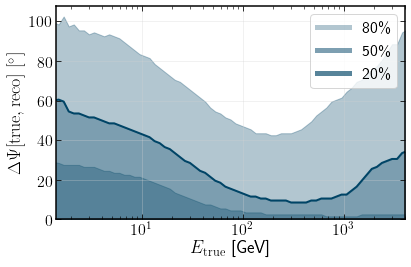

In [6]:
a = greco_ana[-1]
data, sig = a.data, a.sig

# create a histogram:
h = hl.hist_slide(
    # slide the bins 5 times along energy, hold them still along angular error
    (5,1),
    # 2D histogram of true energy and angular error in degrees
    (sig.true_energy, sig.dpsi_deg),
    # E^-2 weighting
    sig.oneweight*sig.true_energy**-2,
    # from 200 GeV to 100 PeV, plus a bit so there are bins at the endpoints
    bins=(10**np.r_[0.0:4.0:.25], np.r_[0:180.01:1])
)

# normalize along the angular error axis
h = h.normalize(1)
# get 20%, 50%, and 80% quantiles
h2 = h.contain(1, .2)
h5 = h.contain(1, .5)
h8 = h.contain(1, .8)

soft_colors = cy.plotting.soft_colors

fig, ax = plt.subplots()

# plot quantiles, emphasize median
color = soft_colors[0]
hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

# trick to get the legend handles colored right
# try testing what happens if you just do hl.fill_between(..., label='...')
nans = [np.nan, np.nan]
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20\%')

# labels etc
ax.semilogx()
ax.set_xlabel(r'$E_\mathrm{true}$ [GeV]')
ax.set_ylabel(r'$\Delta\Psi[\mathrm{true,reco}]~[^\circ]$')
ax.set_xlim(h.bins[0][1], h.bins[0][-2])
ax.set_ylim(0)
ax.legend(loc='upper right')
plt.tight_layout()

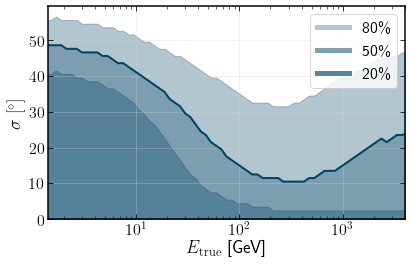

In [7]:
# create a histogram:
h = hl.hist_slide(
    # slide the bins 5 times along energy, hold them still along angular error
    (5,1),
    # 2D histogram of true energy and angular error in degrees
    (sig.true_energy, sig.sigma_deg),
    # E^-2 weighting
    sig.oneweight*sig.true_energy**-2,
    # from 200 GeV to 100 PeV, plus a bit so there are bins at the endpoints
    bins=(10**np.r_[0.0:4.0:.25], np.r_[0:180.01:1])
)

# normalize along the angular error axis
h = h.normalize(1)
# get 20%, 50%, and 80% quantiles
h2 = h.contain(1, .2)
h5 = h.contain(1, .5)
h8 = h.contain(1, .8)

soft_colors = cy.plotting.soft_colors

fig, ax = plt.subplots()

# plot quantiles, emphasize median
color = soft_colors[0]
hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

# trick to get the legend handles colored right
# try testing what happens if you just do hl.fill_between(..., label='...')
nans = [np.nan, np.nan]
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20\%')

# labels etc
ax.semilogx()
ax.set_xlabel(r'$E_\mathrm{true}$ [GeV]')
ax.set_ylabel(r'$\sigma~[^\circ]$')
ax.set_xlim(h.bins[0][1], h.bins[0][-2])
ax.set_ylim(0)
ax.legend(loc='upper right')
plt.tight_layout()

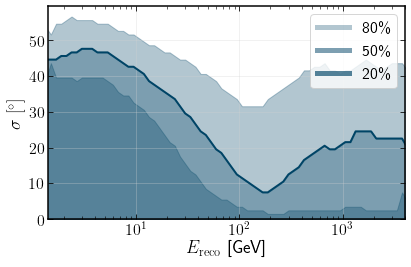

In [8]:
# create a histogram:
h = hl.hist_slide(
    # slide the bins 5 times along energy, hold them still along angular error
    (5,1),
    # 2D histogram of true energy and angular error in degrees
    (sig.energy, sig.sigma_deg),
    # E^-2 weighting
    sig.oneweight*sig.true_energy**-2,
    # from 200 GeV to 100 PeV, plus a bit so there are bins at the endpoints
    bins=(10**np.r_[0.0:4.0:.25], np.r_[0:180.01:1])
)

# normalize along the angular error axis
h = h.normalize(1)
# get 20%, 50%, and 80% quantiles
h2 = h.contain(1, .2)
h5 = h.contain(1, .5)
h8 = h.contain(1, .8)

soft_colors = cy.plotting.soft_colors

fig, ax = plt.subplots()

# plot quantiles, emphasize median
color = soft_colors[0]
hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

# trick to get the legend handles colored right
# try testing what happens if you just do hl.fill_between(..., label='...')
nans = [np.nan, np.nan]
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20\%')

# labels etc
ax.semilogx()
ax.set_xlabel(r'$E_\mathrm{reco}$ [GeV]')
ax.set_ylabel(r'$\sigma~[^\circ]$')
ax.set_xlim(h.bins[0][1], h.bins[0][-2])
ax.set_ylim(0)
ax.legend(loc='upper right')
plt.tight_layout()

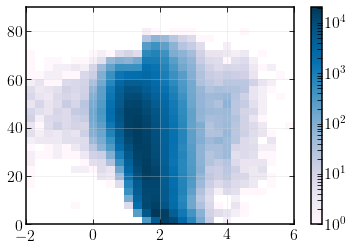

In [29]:
plt.hist2d(np.log10(data.energy), data.sigma_deg,
          bins=[np.linspace(-2., 6., 31), np.linspace(0., 90., 31)],
          norm=LogNorm()
          )
plt.colorbar()
#plt.xscale('log')
plt.show()

305573


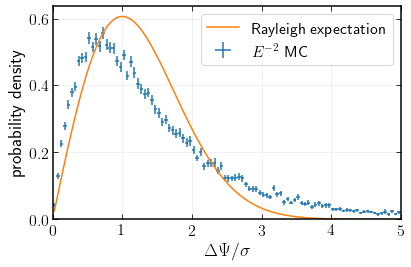

303983


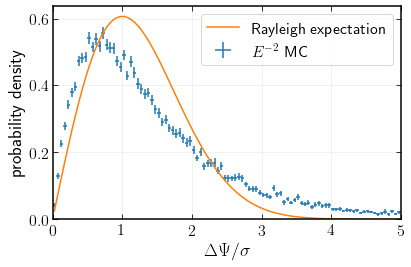

258619


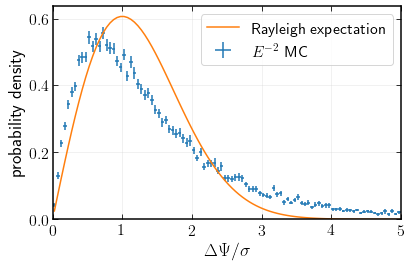

In [17]:
for cut in [0.0, 0.5, 1.0]:
    mc_msk = sig.log10energy > cut
    masked_sig = sig[mc_msk]
    print(len(masked_sig))

    fig, ax = plt.subplots()
    h = hl.hist(masked_sig.dpsi/masked_sig.sigma * 1.0, 
                masked_sig.oneweight*masked_sig.true_energy**-2,
                bins=np.r_[:180:.05]).normalize()
    hl.plot1d(ax, h, crosses=True, label=r'$E^{-2}$ MC')
    x = h.centers[0]
    ax.plot(x, stats.rayleigh.pdf(x), label='Rayleigh expectation')
    ax.set_xlim(0, 5)
    ax.set_ylim(0)
    ax.set_xlabel(r'$\Delta\Psi/\sigma$')
    ax.set_ylabel(r'probability density')
    ax.legend()
    plt.tight_layout()
    
    plt.show()

In [144]:
ra = 0.0; dec = np.radians(0.0)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

# src = cy.utils.Sources(ra=[ra, np.pi/2.],
#                        dec=[dec, np.pi/4.],
#                        mjd=[57000., 57000.], 
#                        sigma_t=[0., 0.],
#                        t_100=[300.0, 300.5])

src = cy.utils.Sources(ra=ra, dec=dec, mjd=57000., sigma_t=0., t_100=1.)

cy.CONF['src'] = src

tr = cy.get_trial_runner(conf, ana=greco_ana)
n_trials=1000
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 5000 background trials using 1 core:
       5000/5000 trials complete.   


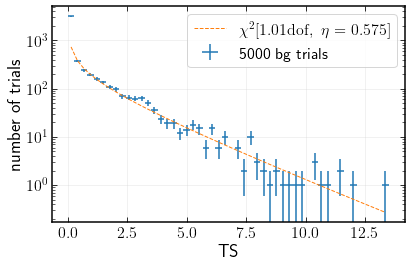

In [145]:
fig, ax = plt.subplots()

h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [146]:
sens = tr.find_n_sig(
        # ts, threshold
        bg.median(),
        # beta, fraction of trials which should exceed the threshold
        0.9,
        # n_inj step size for initial scan
        n_sig_step=5,
        # this many trials at a time
        batch_size=500,
        # tolerance, as estimated relative error
        tol=.05
    )

Start time: 2020-07-22 11:56:56.283606
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.032...
  n_sig = 5.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    2.00    4.00    6.00    8.00   10.00  |  n_sig(relative error)
500      |         50.4%   77.0%   88.0%   95.2%   98.8%   99.8%  |      4.470 (+/-  6.1%) [spline]
1000     |         49.2%   77.7%   88.3%   95.1%   98.9%   99.6%  |      4.423 (+/-  4.5%) [spline]
End time: 2020-07-22 11:58:44.195982
Elapsed time: 0:01:47.912376


In [147]:
disc = tr.find_n_sig(bg.isf_nsigma(3), 0.5, n_sig_step=5, batch_size=500, tol=.05)

Start time: 2020-07-22 11:58:50.108397
Using 1 cores.
* Starting initial scan for 50% of 50 trials with TS >= 10.921...
  n_sig = 5.000 ... frac = 0.46000
  n_sig = 10.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    4.00    8.00   12.00   16.00   20.00  |  n_sig(relative error)
500      |          0.0%   36.4%   68.6%   89.2%   97.8%   98.4%  |      5.572 (+/-  3.3%) [spline]
End time: 2020-07-22 11:59:47.355682
Elapsed time: 0:00:57.247285


In [148]:
print(sens['n_sig'], disc['n_sig'])

4.422650454752824 5.5716173959028445


In [149]:
fmt = '{:.3e}  TeV/cm2/s @ 100 TeV'
# either the number of events or the whole dict will work
print(fmt.format(tr.to_E2dNdE(sens, E0=100, unit=1e3)))
print(fmt.format(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3)))

5.658e-03  TeV/cm2/s @ 100 TeV
7.127e-03  TeV/cm2/s @ 100 TeV


In [150]:
n_sigs = np.r_[:101:10]

trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials)

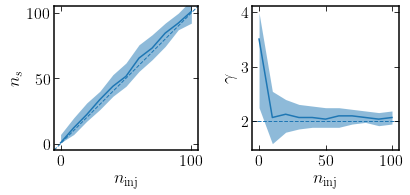

In [152]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()

In [153]:
result = ts, ns, gamma = tr.get_one_fit(TRUTH=True)
print(result)

[0.0, 0.0, 4.0]


In [154]:
print(tr.format_result(tr.get_one_fit(TRUTH=True)))

TS                  0.0
ns                  0.0
gamma               4.0


# Scaling up

In [4]:
trials_dir = cy.utils.ensure_dir('/data/user/apizzuto/Nova/analysis_trials/learning_csky/')

In [5]:
dec_degs = np.r_[-85:85.1:10]

In [6]:
decs = np.radians(dec_degs)
sindecs = np.sin(decs)

In [9]:
bg_dir = cy.utils.ensure_dir('{}/bg'.format(trials_dir))
conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient'
       }


def do_background_trials(dec_deg, N=1000, seed=0):
    # get trial runner
    dec = np.radians(dec_deg)
    src = cy.sources(0, dec, mjd=57000., sigma_t=0., t_100=1000. / 86400.)
    tr = cy.get_trial_runner(conf, src=src, ana=greco_ana)
    # run trials
    trials = tr.get_many_fits(N, seed=seed, logging=False)
    # save to disk
    dir = cy.utils.ensure_dir('{}/dec/{:+04.0f}'.format(bg_dir, dec_deg))
    filename = '{}/trials__N_{:06d}_seed_{:04d}.npy'.format(dir, N, seed)
    print('->', filename)
    # notice: trials.as_array is a numpy structured array, not a cy.utils.Arrays
    np.save(filename, trials.as_array)

In [10]:
do_background_trials(5)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/+005/trials__N_001000_seed_0000.npy


In [11]:
import os
os.remove(trials_dir + 'bg/dec/+005/trials__N_001000_seed_0000.npy')

In [12]:
n_jobs = 2
N = 500

# in real life you should keep track of compute time within your jobs
for dec_deg in dec_degs:
    for seed in range(n_jobs):
        do_background_trials(dec_deg, N=N, seed=seed)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-085/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-085/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-075/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-075/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-065/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-065/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-055/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-055/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-045/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//bg/dec/-045/trials__N_0

In [13]:
def ndarray_to_Chi2TSD(trials):
    return cy.dists.Chi2TSD(cy.utils.Arrays(trials))

In [14]:
 bg = cy.bk.get_all(
        # disk location
        '{}/dec'.format(bg_dir),
        # filename pattern
        'trials*npy',
        # how to combine items within each directory
        merge=np.concatenate,
        # what to do with items after merge
        post_convert=ndarray_to_Chi2TSD)

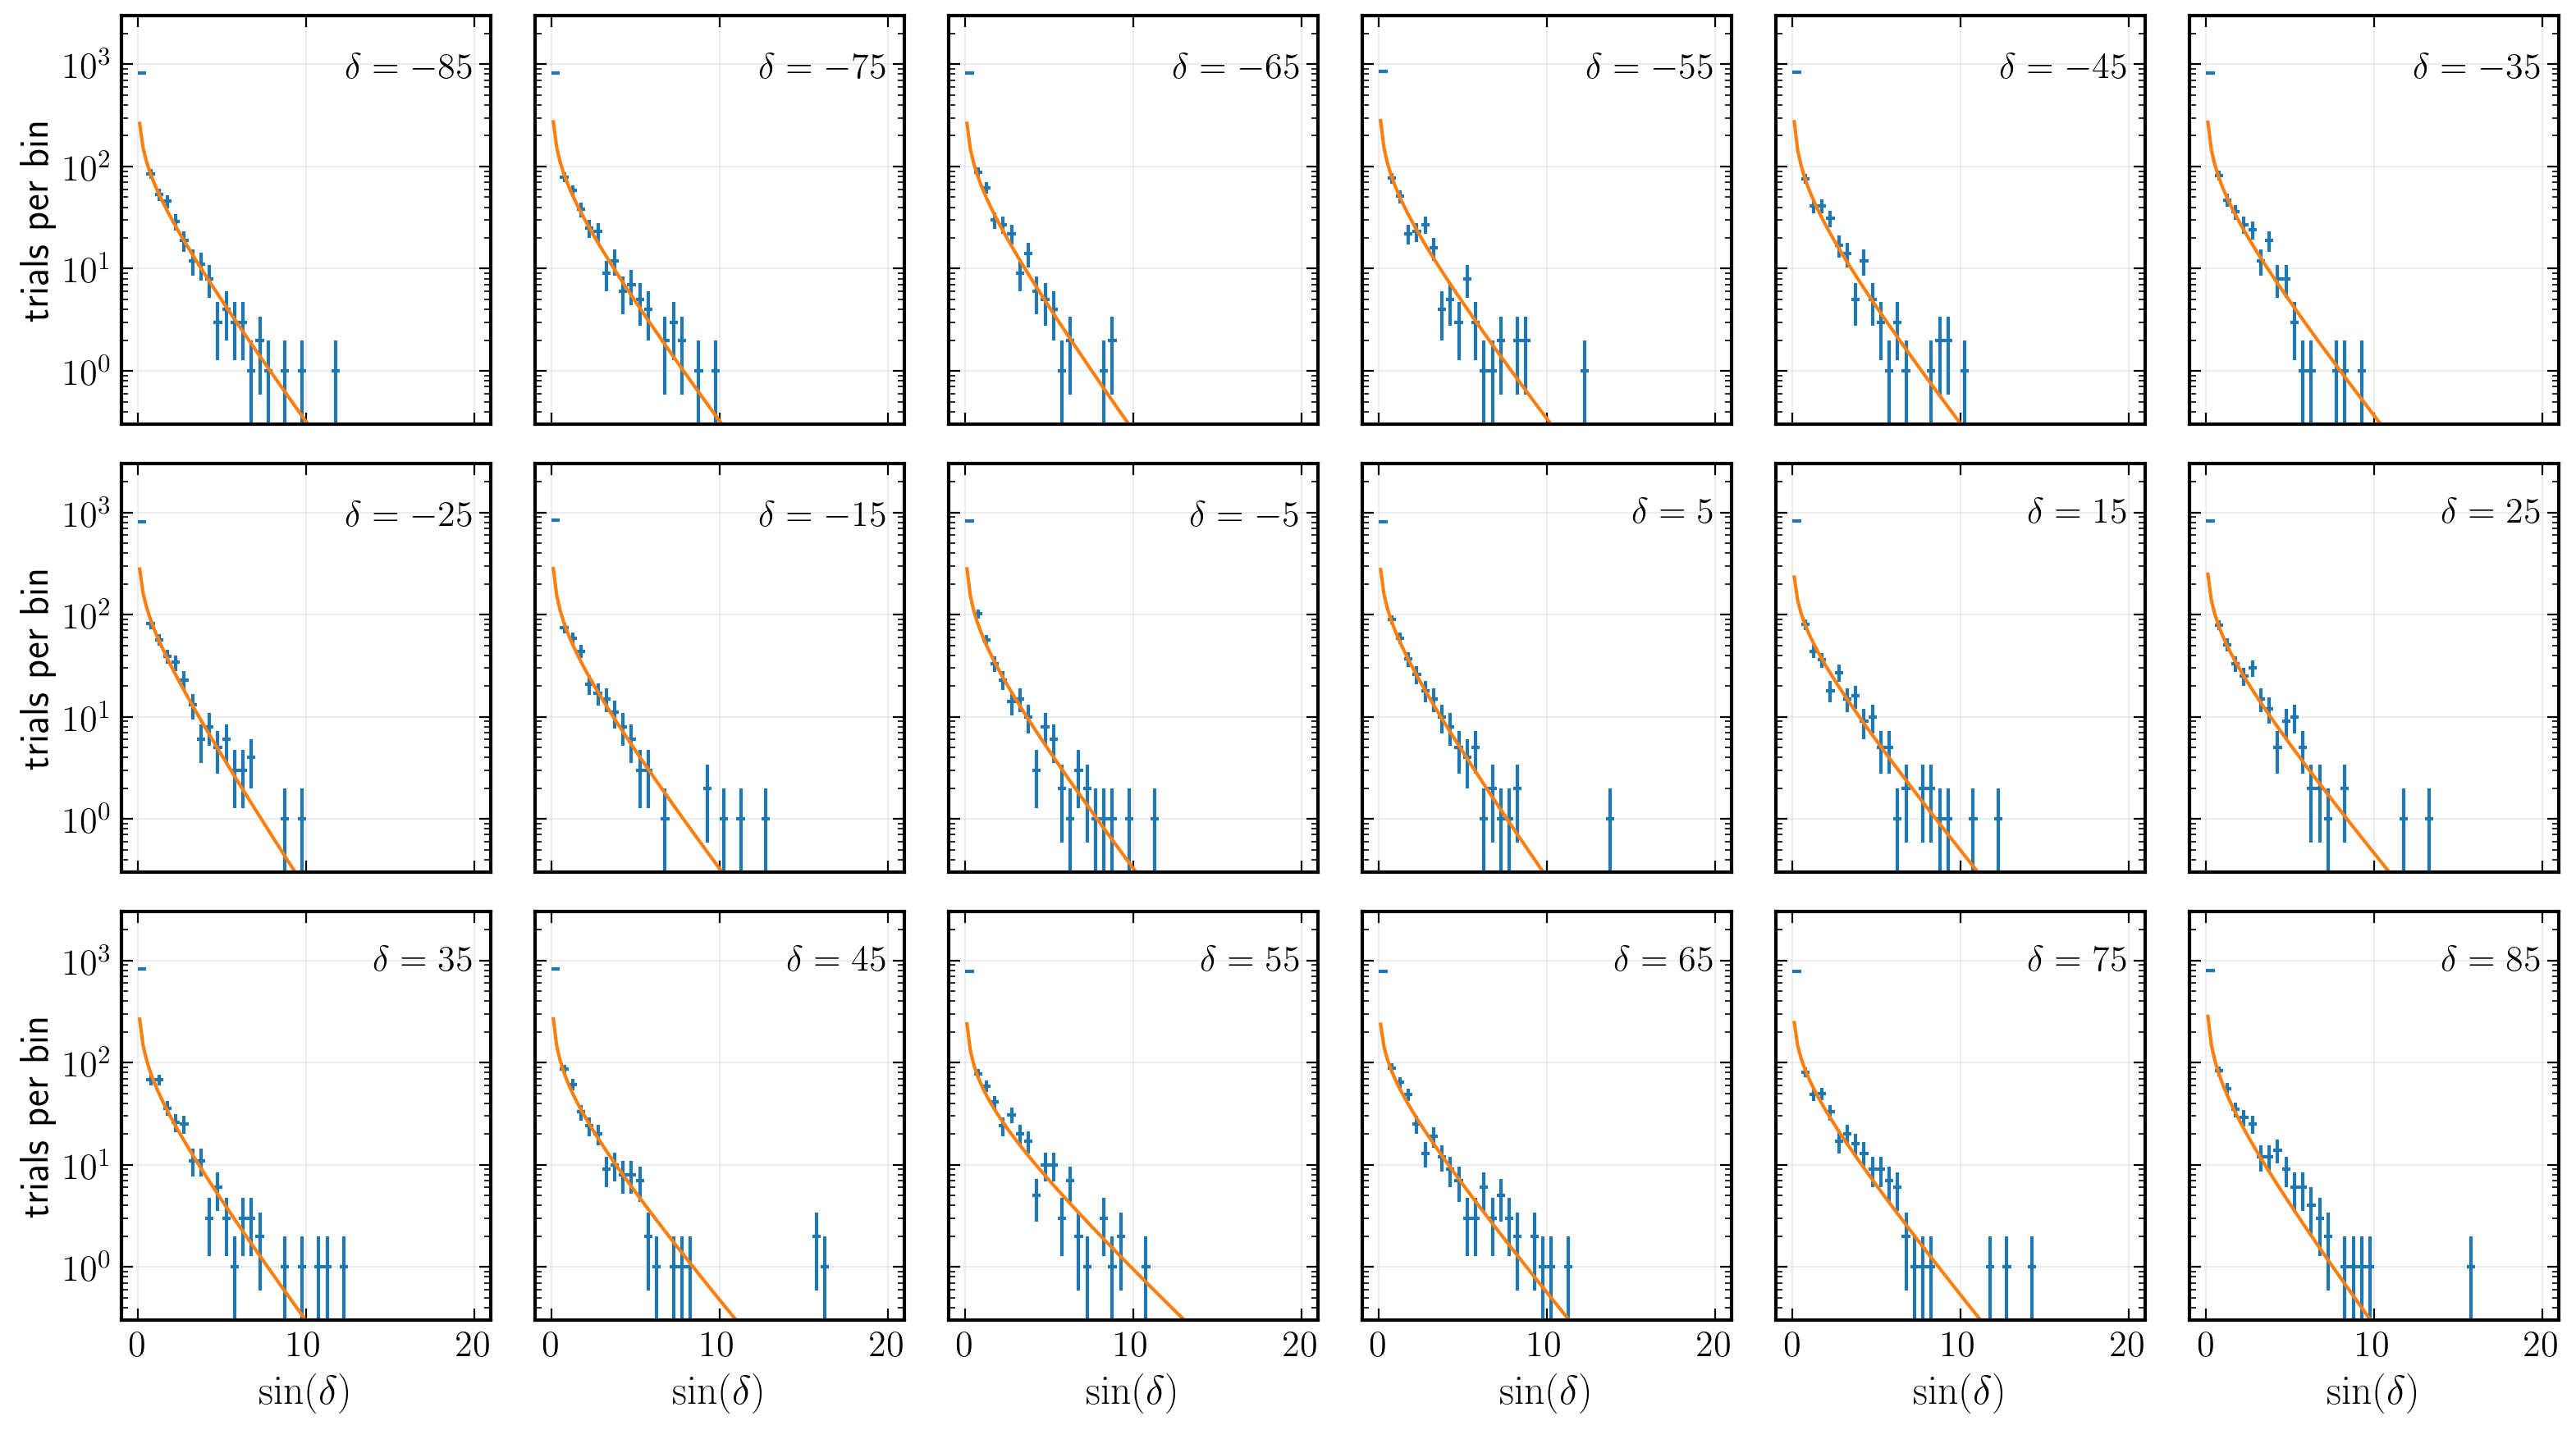

In [18]:
# just choose enough nrow x ncol to fit the whole grid
nrow, ncol = 3, 6
fig, aaxs = plt.subplots(nrow, ncol, figsize=(16,9), sharex=True, sharey=True, dpi=200)
axs = np.ravel(aaxs)
# keep track of which ax's we already used
used_axs = []
for (i, dec_deg) in enumerate(dec_degs):
    ax = axs[i]
    # plot histogram
    b = bg[dec_deg]
    h = b.get_hist(bins=40, range=(0, 20))
    hl.plot1d(ax, h, crosses=True)
    # plot chi2 fit to nonzero values
    norm = h.integrate().values
    ts = np.linspace(.1, h.range[0][1], 100)
    ax.plot(ts, norm * b.pdf(ts))
    # set limits and label dec
    ax.semilogy(nonposy='clip')
    ax.set_ylim(.3, 3e3)
    ax.text(20, 1e3, r'$\delta={:.0f}$'.format(dec_deg), ha='right', va='center')
    used_axs.append(ax)
# hide unused ax's
for ax in axs:
    if ax not in used_axs:
        ax.set_visible(False)
# add x and y labels
for ax in aaxs[-1]:
    if ax in used_axs:
        ax.set_xlabel(r'$\sin(\delta)$')
for ax in aaxs[:,0]:
    ax.set_ylabel(r'trials per bin')
plt.tight_layout()

In [19]:
etas = np.array([bg[d].eta for d in dec_degs])
ndofs = np.array([bg[d].ndof for d in dec_degs])
locs = np.array([bg[d].loc for d in dec_degs])
scales = np.array([bg[d].scale for d in dec_degs])

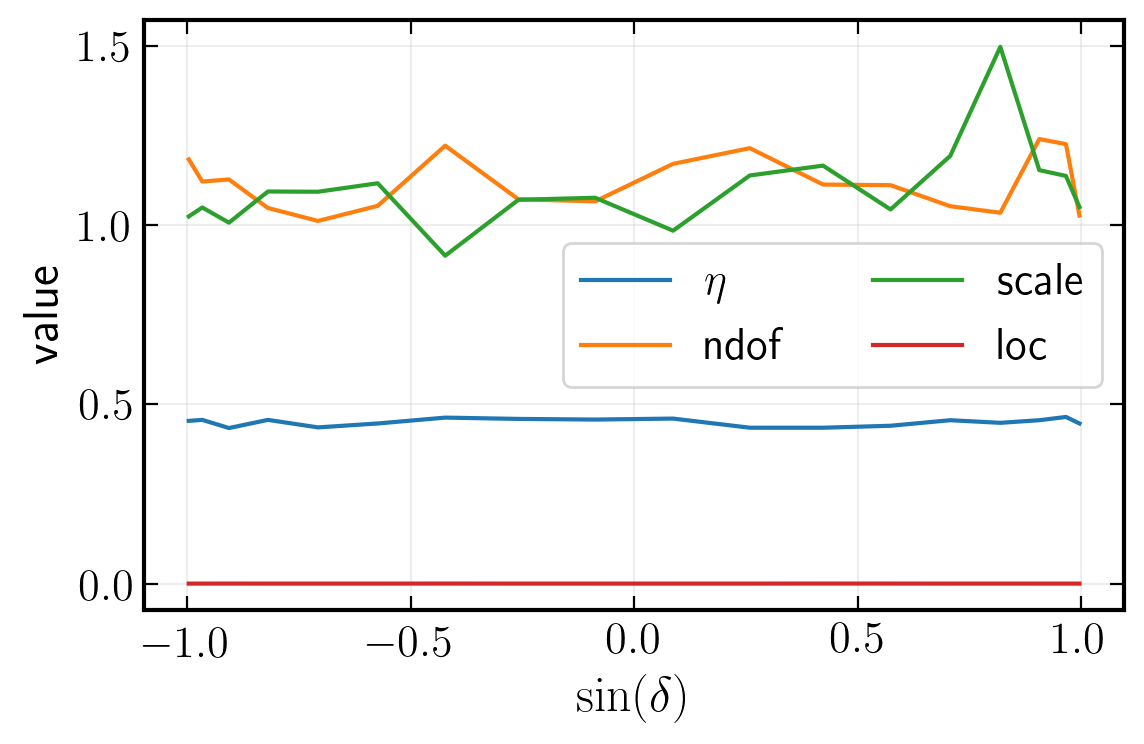

In [21]:
fig, ax = plt.subplots(dpi=200)
ax.plot(sindecs, etas, label=r'$\eta$')
ax.plot(sindecs, ndofs, label='ndof')
ax.plot(sindecs, scales, label='scale')
ax.plot(sindecs, locs, label='loc')
ax.legend(ncol=2)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'value')
plt.tight_layout()

In [22]:
sig_dir = cy.utils.ensure_dir('{}/sig'.format(trials_dir))

def do_signal_trials(dec_deg, n_sig, N=1000, seed=0):
    # get trial runner
    dec = np.radians(dec_deg)
    src = cy.sources(0, dec, mjd=57000., sigma_t=0., t_100=1000./86400.)
    tr = cy.get_trial_runner(conf, src=src, ana=greco_ana)
    # run trials
    trials = tr.get_many_fits(N, n_sig, seed=seed, logging=False)
    # save to disk
    dir = cy.utils.ensure_dir('{}/dec/{:+04.0f}/nsig/{:05.1f}'.format(sig_dir, dec_deg, n_sig))
    filename = '{}/trials__N_{:06d}_seed_{:04d}.npy'.format(dir, N, seed)
    print('->', filename)
    # notice: trials.as_array is a numpy structured array, not a cy.utils.Arrays
    np.save(filename, trials.as_array)

In [247]:
tr = cy.get_trial_runner(conf, src=src, ana=greco_ana, inj_conf={'flux': cy.hyp.PowerLawFlux(3.)})

n_sigs = np.r_[:101:10]

trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials)

In [236]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()

array([1.9711568 , 1.29727413, 1.65931587, 2.36155943, 2.38833759,
       1.87968004, 1.85202064, 1.5443393 , 1.74795661, 1.77036559,
       2.16548113, 1.91241115, 2.4250522 , 2.35271591, 1.57367097,
       1.89636912, 2.08028226, 2.06751813, 2.20148278, 1.57779483,
       2.03353555, 1.55547086, 1.90688321, 2.31161858, 1.50151865,
       1.39993599, 2.09153862, 2.18469941, 1.95362038, 1.92338789,
       2.4709152 , 2.01774112, 2.06912301, 1.81488517, 2.12533721,
       2.1310432 , 2.27478124, 1.52217317, 1.66704053, 2.40473706,
       1.89091631, 1.61618923, 1.54670976, 2.6369381 , 2.51404827,
       2.18528805, 1.98947245, 1.50261075, 2.20911744, 2.17600452,
       1.40635092, 1.40625966, 1.63239322, 2.20082213, 1.87446075,
       2.58833706, 2.204658  , 1.51027739, 2.5550161 , 2.18267417,
       1.80634172, 2.29810504, 1.80283352, 2.03552036, 2.22240448,
       1.79696586, 2.28132278, 2.49398448, 2.14492932, 2.11239966,
       2.20171538, 1.65653021, 1.72441785, 2.34147177, 2.38528

In [218]:
N = 500
n_jobs = 2
n_sigs = np.r_[2:10:2, 10:30.1:5]

for dec_deg in dec_degs:
    for n_sig in n_sigs:
        for seed in range(n_jobs):
            do_signal_trials(dec_deg, n_sig, N=N, seed=seed)

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/002.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/002.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/004.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/004.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/006.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/006.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/008.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/008.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-085/nsig/010.0/trial

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/002.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/004.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/004.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/006.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/006.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/008.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/008.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/010.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-045/nsig/010.0/trial

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/002.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/004.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/004.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/006.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/006.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/008.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/008.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/010.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/-005/nsig/010.0/trial

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/002.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/004.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/004.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/006.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/006.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/008.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/008.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/010.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+035/nsig/010.0/trial

-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/002.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/004.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/004.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/006.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/006.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/008.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/008.0/trials__N_000500_seed_0001.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/010.0/trials__N_000500_seed_0000.npy
-> /data/user/apizzuto/Nova/analysis_trials/learning_csky//sig/dec/+075/nsig/010.0/trial

In [224]:
sig = cy.bk.get_all(sig_dir, 'trials*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)

In [226]:
trs = {d: cy.get_trial_runner(conf, src=cy.sources(0, d, deg=True, mjd=57000., sigma_t=0., t_100=2.), ana=greco_ana) for d in dec_degs}

In [227]:
@np.vectorize
def find_n_sig(dec_deg, beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'dec', dec_deg, 'nsig')
    b = cy.bk.get_best(bg, dec_deg)
    tr = cy.bk.get_best(trs, dec_deg)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # include background trials in calculation
    trials = {0: b.trials}
    trials.update(sig_trials)
    # get number of signal events
    # (arguments prevent additional trials from being run)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=100, unit=1e3)

In [230]:
fluxs_sens = find_n_sig(dec_degs)
fluxs_disc = find_n_sig(dec_degs, beta=0.5, nsigma=3)

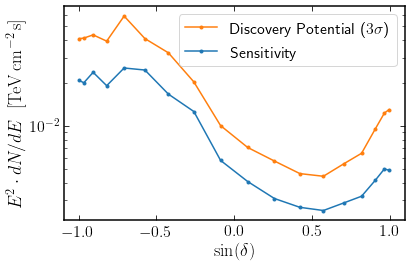

In [232]:
fig, ax = plt.subplots()
# '.-' dot-plus-line style not attractive, but useful for early-stage plotting
ax.semilogy(sindecs, fluxs_disc, '.-', color='C1', label=r'Discovery Potential ($3\sigma$)')
ax.semilogy(sindecs, fluxs_sens, '.-', color='C0', label=r'Sensitivity')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2\cdot dN/dE\ \ [\mathrm{TeV}\,\mathrm{cm}^{-2}\,\mathrm{s}]$')
ax.legend()
ax.grid()
plt.tight_layout()

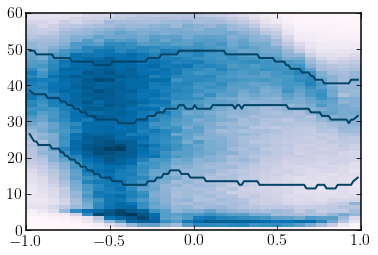

In [194]:
hl.hist((np.sin(data.dec), data.sigma_deg), bins=(np.linspace(-1., 1., 31), np.r_[0:60.01:1]))
h = h.normalize(1)
h2 = h.contain(1, .2)
h5 = h.contain(1, .5)
h8 = h.contain(1, .8)

fig, ax = plt.subplots()
plt.hist2d(np.sin(data.dec), data.sigma_deg, bins=(np.linspace(-1., 1., 31), np.r_[0:60.01:1]))
hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')
hl.plot1d (ax, h2, color=color, lw=2, drawstyle='default')
hl.plot1d (ax, h8, color=color, lw=2, drawstyle='default')



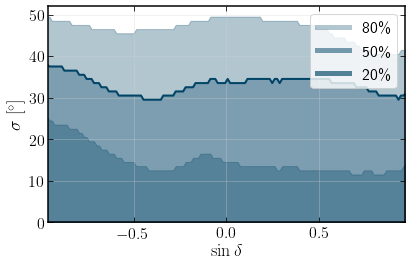

In [187]:
# create a histogram:
h = hl.hist_slide(
    # slide the bins 5 times along energy, hold them still along angular error
    (5,1),
    # 2D histogram of true energy and angular error in degrees
    (np.sin(data.dec), data.sigma_deg),
    # E^-2 weighting
    #sig.oneweight*sig.true_energy**-2,
    # from 200 GeV to 100 PeV, plus a bit so there are bins at the endpoints
    bins=(np.linspace(-1., 1., 31), np.r_[0:180.01:1])
)

# normalize along the angular error axis
h = h.normalize(1)
# get 20%, 50%, and 80% quantiles
h2 = h.contain(1, .2)
h5 = h.contain(1, .5)
h8 = h.contain(1, .8)

soft_colors = cy.plotting.soft_colors

fig, ax = plt.subplots()

# plot quantiles, emphasize median
color = soft_colors[0]
hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

# trick to get the legend handles colored right
# try testing what happens if you just do hl.fill_between(..., label='...')
nans = [np.nan, np.nan]
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50\%')
ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20\%')

# labels etc
#ax.semilogx()
ax.set_xlabel(r'$\sin \delta$')
ax.set_ylabel(r'$\sigma~[^\circ]$')
ax.set_xlim(h.bins[0][1], h.bins[0][-2])
ax.set_ylim(0)
ax.legend(loc='upper right')
plt.tight_layout()

In [189]:
?hl.hist

In [199]:
ra = 0.0; dec = np.radians(0.0)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

src = cy.utils.Sources(ra=[ra, np.pi/2., np.pi],
                       dec=[dec, np.pi/4., -np.pi/4.],
                       mjd=[57000., 57000., 57500.], 
                       sigma_t=[0., 0., 0.],
                       t_100=[1.0, 1.5, 0.4])

#src = cy.utils.Sources(ra=ra, dec=dec, mjd=57000., sigma_t=0., t_100=1.)

cy.CONF['src'] = src

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials=1000
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 1000 background trials using 1 core:
       1000/1000 trials complete.   


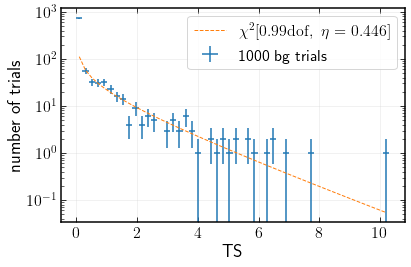

In [200]:
fig, ax = plt.subplots()

h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [252]:
fl = cy.hyp.PowerLawFlux(3., energy_range=(10., 100.))

In [254]:
?cy.hyp.PowerLawFlux